Aim 1: design a pseudo bulk estimation procedure using random projection and tree data structure.

In [1]:
from util._io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
import fastsca
import logging
import _rpstruct as rp
import importlib
importlib.reload(rp)
from sklearn.metrics.cluster import contingency_matrix,adjusted_rand_score
import matplotlib.pylab as plt
import seaborn as sns
import _scanpy as s
np.random.seed(42)

experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sca = fastsca.FASTSCA()
sca.config = args
sca.initdata()
sca.loaddata()
sca.data.mtx.shape
fn = sca.config.home + sca.config.experiment +sca.config.output + sca.config.sample_id+'/'+sca.config.sample_id

In [ ]:
## generate scanpy 
s.run_scanpy(sca.data.mtx,sca.data.rows,sca.data.cols,fn)

In [5]:
## generate rp 
min_leaf = 250
max_depth = 25


rp_mat = []
for i in range(max_depth):
    rp_mat.append(np.random.normal(size = (sca.data.mtx.shape[1],1)).flatten())

rp_mat = np.asarray(rp_mat)
rp_mat.shape

tree = rp.StepTree(sca.data.mtx,rp_mat)
tree.build_tree(min_leaf,max_depth)
bulkd = tree.make_bulk()
print(len(bulkd))
sum = 0
for k in bulkd.keys(): sum += len(bulkd[k])
print(sum)


bulk = {}
for key, value in bulkd.items(): 
    bulk[key] = np.asarray(sca.data.mtx[value].sum(0))[0]
pd.DataFrame.from_dict(bulk,orient='index').to_csv(fn+"_rp_bulk.csv.gz",compression='gzip',index=False)

1146
100064


Validation of bulk data

In [7]:
bulk_index = {}
for key, value in bulkd.items(): 
    bulk_index[key] = value

df_index = pd.DataFrame.from_dict(bulk_index,orient='index')
df_index.to_csv(fn+"_rp_bulk_index.csv.gz",compression='gzip',index=False)
df_index.shape


(1146, 1108)

Text(3.674999999999997, 0.5, 'Pseudobulk count')

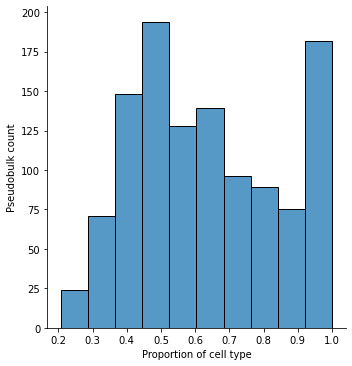

In [2]:
df_gt = pd.read_csv(fn+'_metadata.csv.gz')
df_index = pd.read_csv(fn+"_rp_bulk_index.csv.gz")
cell_topic_assignment = []
for indx,row in df_index.iterrows():
    for i in row[pd.Series(row).notna()].values:
        i = int(i)
        cell_topic_assignment.append([ indx, df_gt.loc[i,'cell'],df_gt.loc[i,'label']])
df_rp = pd.DataFrame(cell_topic_assignment,columns=['tree_leaf','cell','label'])
df_match = pd.DataFrame(contingency_matrix(df_rp.tree_leaf,df_rp.label))
df_match = df_match.div(df_match.sum(axis=1), axis=0)
sns.displot(df_match.max(1).values,bins=10)
plt.xlabel('Proportion of cell type')
plt.ylabel('Pseudobulk count')

Text(10.049999999999997, 0.5, 'Leiden group count')

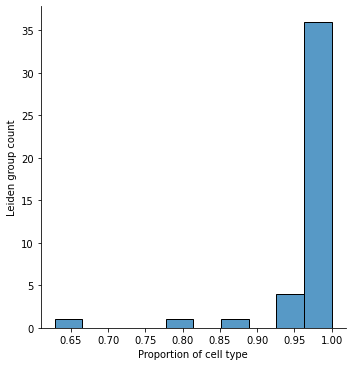

In [9]:
#positive control 

df_scanpy = pd.read_csv(fn+'_scanpy_label.csv.gz')
df_join = pd.merge(df_scanpy,df_gt,on='cell',how='left')
df_scmatch = pd.DataFrame(contingency_matrix(df_join.label_x,df_join.label_y))
df_scmatch = df_scmatch.div(df_scmatch.sum(axis=1), axis=0)
sns.displot(df_scmatch.max(1).values,bins=10)
plt.xlabel('Proportion of cell type')
plt.ylabel('Leiden group count')

Text(3.674999999999997, 0.5, 'Random group count')

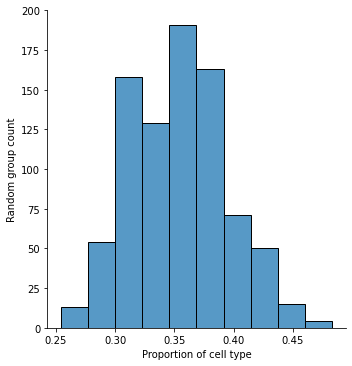

In [10]:
arr = np.arange(sca.data.mtx.shape[0])
np.random.shuffle(arr)
n=848
df_index_r = pd.DataFrame([arr[i:i + n] for i in range(0, len(arr), n)])
df_index_r = df_index_r.T
cell_topic_assignment = []
for indx,row in df_index_r.iterrows():
    for i in row[pd.Series(row).notna()].values:
        cell_topic_assignment.append([ indx, df_gt.loc[i,'cell'],df_gt.loc[i,'label']])
df_r = pd.DataFrame(cell_topic_assignment,columns=['tree_leaf','cell','label'])
df_rmatch = pd.DataFrame(contingency_matrix(df_r.tree_leaf,df_r.label))
df_rmatch = df_rmatch.div(df_rmatch.sum(axis=1), axis=0)
sns.displot(df_rmatch.max(1).values,bins=10)
plt.xlabel('Proportion of cell type')
plt.ylabel('Random group count')

In [8]:
dfrows = pd.DataFrame(sca.data.rows,columns=['cell'])
dfjoin = pd.merge(dfrows,df_rp,how='left',on='cell')
dfjoin

,cell,tree_leaf,label
0,CID3586_AAGACCTCAGCATGAG,1091,Endothelial
1,CID3586_AAGGTTCGTAGTACCT,1143,Endothelial
2,CID3586_ACCAGTAGTTGTGGCC,1092,Endothelial
3,CID3586_ACCCACTAGATGTCGG,1092,Endothelial
4,CID3586_ACTGATGGTCAACTGT,1143,Endothelial
...,...,...,...
100059,CID4398_TCAGGTAGTACTCAAC,605,Myeloid
100060,CID4398_TCTATTGTCGCCATAA,1120,Myeloid
100061,CID4398_TCTTTCCCAGTAAGCG,832,Myeloid
100062,CID4398_TGCCCATGTTACGGAG,1120,Myeloid


In [12]:
from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score

print(davies_bouldin_score(sca.data.mtx,dfjoin.label))

/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


4.662492975080541
